# 水平指定地点近傍の地表面変数・高層大気変数

地上観測データや高層気象観測データと比較することを念頭に, モデル出力からある指定した水平地点の近くのデータを抽出するノートブックです. ここではtutorial/realのヒストリから, 神戸付近のデータを抽出する例を示します.


## ライブラリの読込
* numpy: 数値計算ライブラリ
* xarray: 
* matplotlib: 描画ライブラリ
* cartopy: 地図ライブラリ
* mod_scale.g_file: SCALE解析ライブラリ(ファイル関係). 現在いるディレクトリにリンクを貼っておく必要がある. (e.g., ln -s /home/hoge/mod_scale ./)

In [1]:
# Import libraries
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mod_scale.g_file import get_xrvar, get_fpathlist
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
plt.rcParams["font.size"]=15

## データ情報の設定
* dir1,dir2: scale-rm/test/tutorial/real/experiment/run へのパス
* domainlabel: "_d01"などのドメインラベル. なければ""
* timelabel: "_20070714-210000.000"などの時間ラベル. なければ""
* PRC_NUM_X,PRC_NUM_Y: SCALE実行時に*.confに指定したプロセス数.

In [2]:
# Data setting
dir1 = "./sampledata/scale-5.4.5/scale-rm/test/tutorial/real/experiment/run/"

domainlabel = "_d01"
timelabel = ""

PRC_NUM_X = 2
PRC_NUM_Y = 2

dir_out = "./fig/"
savefig = True

## データ処理の設定
* sfcvarname: 地表面変数
* uppvarname: 高層大気変数
* lon0,lat0,dist0: ターゲット経度, ターゲット緯度, 近傍とみなす水平距離 (km)

In [3]:
# Target surface variable
sfcvarname = "MSLP"
sfcvarunit = "(hPa)"
sfcvarfact = 1e-2

# Target upper air variable
uppvarname = "RH"
uppvarunit = "(%)"
uppvarfact = 1
uppvarlevels = np.linspace(0,100,21)
uppvarcmap = "BrBG"

# Target location
lon0 = 135.2207105
lat0 = 34.6533937
dist0 = 50 # km


# 描画設定

In [4]:

xticks=[130,135,140]
yticks=[30,35,40]
xticks_f = np.array([tmp for tmp in np.linspace(np.floor(lon0)-2,np.floor(lon0)+2,5)])
yticks_f = np.array([tmp for tmp in np.linspace(np.floor(lat0)-2,np.floor(lat0)+2,5)])


# データ処理
* ファイルの読込

In [5]:
# Read history
fpathlist =  get_fpathlist(dir1,"history",domainlabel,timelabel,PRC_NUM_X,PRC_NUM_Y)
xrvar = get_xrvar(fpathlist)
time = xrvar.coords["time"]
tsize = len(time)
lon = xrvar.coords["lon"]
lat = xrvar.coords["lat"]
z = xrvar.coords["z"]

* 指定地点からの水平距離の計算

In [6]:
# Calculate distance from target
def ll2dist(lat1,lon1,lat2,lon2):
    R = 6371
    return R * np.arccos(
        np.sin(np.radians(lat1))*np.sin(np.radians(lat2))
        +np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*
        np.cos(np.radians(lon1)-np.radians(lon2)))
dist = ll2dist(lat0,lon0,lat,lon)

# Near points
lon_lim = lon.values[dist<dist0]
lat_lim = lat.values[dist<dist0]

# Nearest point
argmin_dist = np.argmin(dist.values.reshape(-1))
lon_nn = lon.values.reshape(-1)[argmin_dist]
lat_nn = lat.values.reshape(-1)[argmin_dist]

* 近傍と判定されるグリッド点の確認のための描画

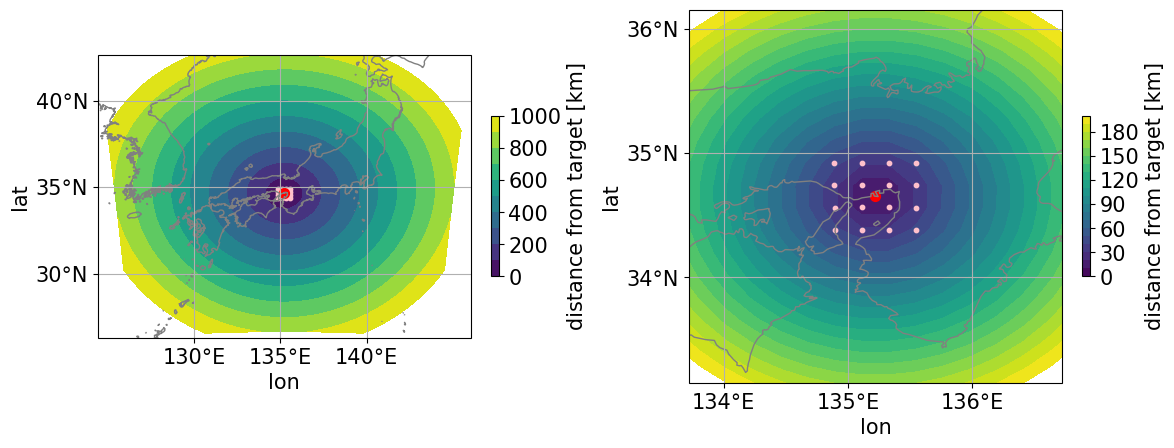

In [7]:
# Check distance from target

fig = plt.figure(figsize=(12,5))
axes = [fig.add_subplot(121,projection=ccrs.PlateCarree()), fig.add_subplot(122,projection=ccrs.PlateCarree())]
for ind,ax in enumerate(axes):
    ax.coastlines('10m',color='gray')
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_aspect("equal")
    ax.set_xlabel("lon")
    ax.set_ylabel("lat")
    if ind==0:
        levels1 = np.linspace(0,1000,11)
        ax.gridlines(xlocs=xticks, ylocs=yticks)
        ax.set_xticks(xticks, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks, crs=ccrs.PlateCarree())
        ax.set_xlim(lon.values.min(),lon.values.max())
        ax.set_ylim(lat.values.min(),lat.values.max())
    else:
        levels1 = np.linspace(0,200,21)
        ax.gridlines(xlocs=xticks_f, ylocs=yticks_f)
        ax.set_xticks(xticks_f, crs=ccrs.PlateCarree())
        ax.set_yticks(yticks_f, crs=ccrs.PlateCarree())
        ax.set_xlim(lon0-1.5,lon0+1.5)
        ax.set_ylim(lat0-1.5,lat0+1.5)
    cax = ax.contourf(lon,lat,dist,levels=levels1)
    cbar = plt.colorbar(cax,ax=ax,fraction=0.02)
    cbar.set_label("distance from target [km]")

    ax.scatter(lon_lim,lat_lim,marker="o",color="pink",s=10) # extracted points
    ax.scatter(lon0,lat0,marker="o",color="r",s=50) # target point

fig.tight_layout()
if savefig:
    fig.savefig(dir_out + f"near_target_lon{lon0:.1f}_lat{lat0:.1f}.png")


* 近傍の変数の抽出

In [8]:
# Nearest and limited variables
sfcvar = xrvar[sfcvarname]
sfcvar_nn = sfcvar.values.reshape(time.size,-1)[:,argmin_dist]
sfcvar_lim = sfcvar.values[:,dist<dist0]

uppvar = xrvar[uppvarname]
uppvar_nn = uppvar.values.reshape(time.size,z.size,-1)[:,:,argmin_dist]
uppvar_lim = uppvar.values[:,:,dist<dist0]

# 描画（地表変数）
* 最近傍グリッド値, 近傍水平平均値, 近傍水平平均±標準偏差, 近傍水平最大–最小の時系列

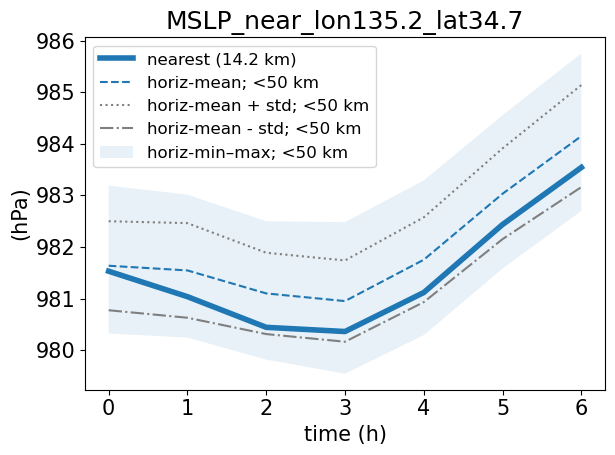

In [9]:
# Surface variable
import matplotlib.cm as cm
fig,ax=plt.subplots()
ax.plot(time/3600,sfcvar_nn*sfcvarfact,label=f"nearest ({dist.values.reshape(-1)[argmin_dist]:.1f} km)",linewidth=4)
ax.plot(time/3600, np.mean(sfcvar_lim,axis=1)*sfcvarfact, color="tab:blue",linestyle="dashed",label=f"horiz-mean; <{dist0} km")
ax.plot(time/3600, (np.mean(sfcvar_lim,axis=1)+np.std(sfcvar_lim,axis=1))*sfcvarfact, color="tab:gray",linestyle="dotted",label=f"horiz-mean + std; <{dist0} km")
ax.plot(time/3600, (np.mean(sfcvar_lim,axis=1)-np.std(sfcvar_lim,axis=1))*sfcvarfact, color="tab:gray",linestyle="dashdot",label=f"horiz-mean - std; <{dist0} km")
ax.fill_between(time/3600, np.max(sfcvar_lim,axis=1)*sfcvarfact, np.min(sfcvar_lim,axis=1)*sfcvarfact,alpha=0.1,facecolor="tab:blue",label=f"horiz-min–max; <{dist0} km")
ax.set_xlabel("time (h)")
ax.set_ylabel(f"{sfcvarunit}")
ax.set_title(f"{sfcvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}")
ax.legend(fontsize=12)

fig.tight_layout()

if savefig:
    fig.savefig(dir_out + f"{sfcvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}.png")


# 描画（高層大気変数）
* 最近傍グリッド値の時間平均値, 近傍水平時間平均値の鉛直分布
* 近傍水平標準偏差の時間平均値, 時間標準偏差の近傍水平平均値の鉛直分布
* 最近傍グリッド値の時間高度分布
* 近傍水平平均値の時間高度分布

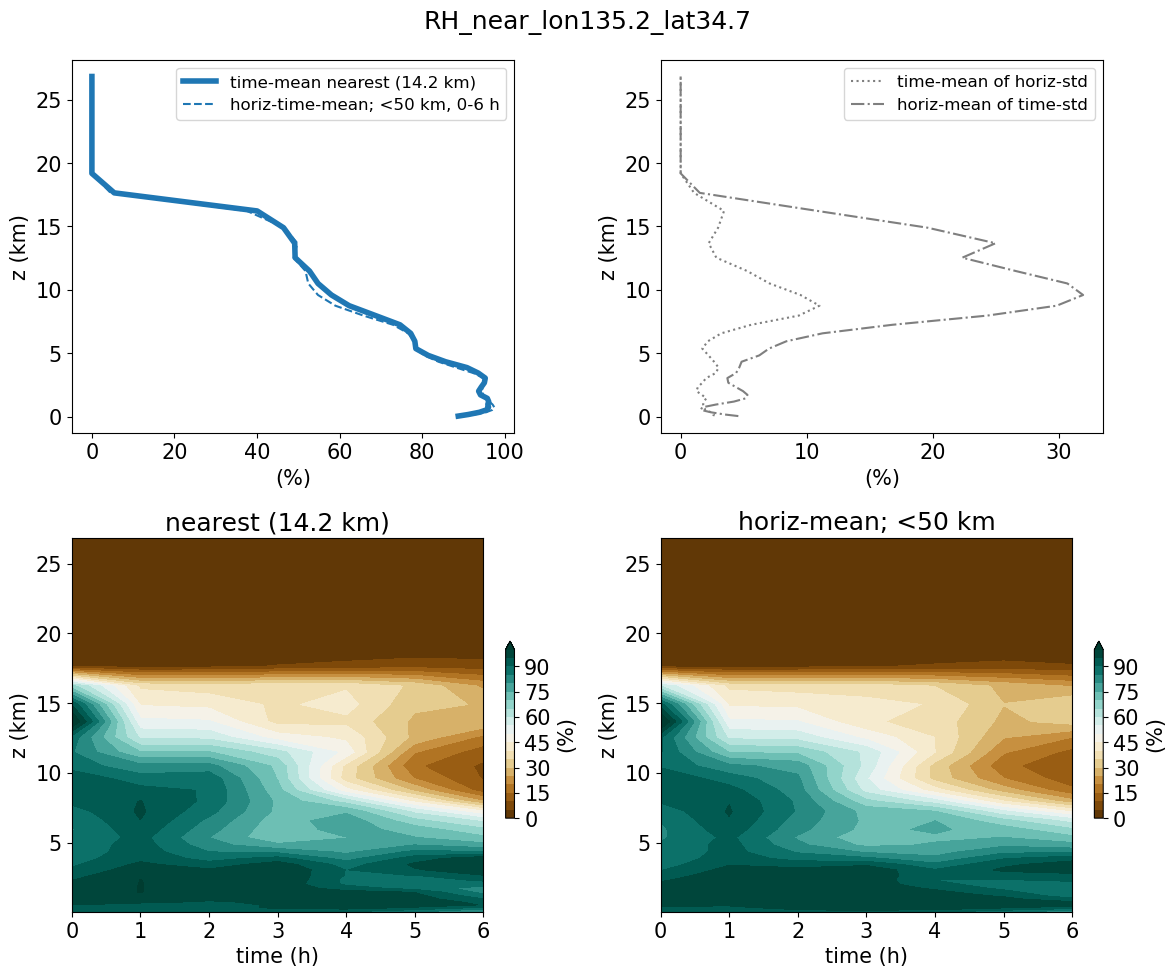

In [10]:
fig,axes=plt.subplots(2,2,figsize=(12,10))
fig.suptitle(f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}")

axes = axes.reshape(-1)

# Upper variable, vertical profile
ax=axes[0]
ax.plot(np.mean(uppvar_nn,axis=0)*uppvarfact,z/1000,label=f"time-mean nearest ({dist.values.reshape(-1)[argmin_dist]:.1f} km)",linewidth=4)
ax.plot(np.mean(uppvar_lim,axis=(0,2))*uppvarfact, z/1000, color="tab:blue",linestyle="dashed",label=f"horiz-time-mean; <{dist0} km, {time[0]/3600:.0f}-{time[-1]/3600:.0f} h")
ax.set_ylabel("z (km)")
ax.set_xlabel(f"{uppvarunit}")
#ax.set_title(f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}")
ax.legend(fontsize=12)

ax=axes[1]
ax.plot(np.mean(np.std(uppvar_lim,axis=2),axis=0)*uppvarfact, z/1000, color="tab:gray",linestyle="dotted",label="time-mean of horiz-std")
ax.plot(np.mean(np.std(uppvar_lim,axis=0),axis=1)*uppvarfact, z/1000, color="tab:gray",linestyle="dashdot",label="horiz-mean of time-std")
ax.set_ylabel("z (km)")
ax.set_xlabel(f"{uppvarunit}")
#ax.set_title(f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}")
ax.legend(fontsize=12)


# Upper variable, time-height, nearest
#fig,ax=plt.subplots()
ax = axes[2]
cax = ax.contourf(time/3600,z/1000,(uppvar_nn*uppvarfact).T,levels=uppvarlevels,cmap=uppvarcmap,extend="max")
cbar = plt.colorbar(cax,ax=ax,fraction=0.02)
cbar.set_label(uppvarunit)
ax.set_ylabel("z (km)")
ax.set_xlabel("time (h)")
#ax.set_title(f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}" + "\n"+ f"nearest ({dist.values.reshape(-1)[argmin_dist]:.1f} km)")
ax.set_title(f"nearest ({dist.values.reshape(-1)[argmin_dist]:.1f} km)")

# Upper variable, time-height, space-mean
#fig,ax=plt.subplots()
ax = axes[3]
cax = ax.contourf(time/3600,z/1000,(np.mean(uppvar_lim,axis=2)*uppvarfact).T,levels=uppvarlevels,cmap=uppvarcmap,extend="max")
cbar = plt.colorbar(cax,ax=ax,fraction=0.02)
cbar.set_label(uppvarunit)
ax.set_ylabel("z (km)")
ax.set_xlabel("time (h)")
#ax.set_title(f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}" + "\n"+f"space-mean; <{dist0} km")
ax.set_title(f"horiz-mean; <{dist0} km")

fig.tight_layout()

if savefig:
    fig.savefig(dir_out + f"{uppvarname}_near_lon{lon0:.1f}_lat{lat0:.1f}.png")